In [20]:
# Importing the required files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from collections import Counter
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [21]:
# Load the original dataset.
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

In [22]:
#  Process 1 - Filter TLS-related traffic.
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[
    (darknet_data['Dst Port'].isin(tls_ports)) &  # Destination port is TLS-related.
    (darknet_data['Protocol'] == 6)              # Protocol is TCP.
]

print("TLS traffic filtered!")

TLS traffic filtered!


In [24]:
#  Process 2 - Encoding the TLS traffic data.

# Creating an object of the LabelEncoder class
label_encoder = LabelEncoder()

# Encode string columns
for column in tls_traffic.select_dtypes(include=['object']).columns:
    # Assign explicitly to avoid warning
    encoded_column = label_encoder.fit_transform(tls_traffic[column])
    tls_traffic.loc[:, column] = encoded_column

print("Encoding Completed!")

Encoding Completed!


In [25]:
# Process 3 - Scaling the TLS traffic data

# Step 1: Make a copy of the DataFrame to avoid SettingWithCopyWarning
tls_traffic = tls_traffic.copy()

# Step 2: Identify Numeric Columns to Scale
# Exclude columns that should not be scaled
columns_to_exclude = ['Protocol', 'Dst Port']  # Add any additional columns to exclude if needed
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Step 3: Check and Replace Invalid Values
# Replace infinity values with NaN
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with column means
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Step 4: Scale Only the Selected Numeric Columns
scaler = MinMaxScaler()
tls_traffic[numeric_columns] = scaler.fit_transform(tls_traffic[numeric_columns])

# Print confirmation
print("Scaling completed!")

Scaling completed!


In [26]:
# Process 4 - SMOTE Class imbalance

# Step 1: Define the target variable and features
X = tls_traffic.drop('Label', axis=1)  # Features
y = tls_traffic['Label']              # Target

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Step 3: Combine features and target back into tls_traffic
tls_traffic = pd.DataFrame(X, columns=X.columns)
tls_traffic['Label'] = y

# Step 4: Display class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y))
print("Class distribution after SMOTE:", Counter(y))

Class distribution before SMOTE: Counter({0: 11395, 1: 11395, 2: 11395, 3: 11395})
Class distribution after SMOTE: Counter({0: 11395, 1: 11395, 2: 11395, 3: 11395})


In [27]:
# Process 5 - Feature Selection.

# Define the target variable.
target_variable = 'Label'

# Calculate the correlation matrix.
correlation_matrix = tls_traffic.corr()

# Extract correlations with the target variable.
target_correlation = correlation_matrix[target_variable].drop(target_variable)

# Set a threshold for correlation (absolute value).
threshold = 0.1  # Adjust this based on your needs (e.g., 0.1 for weak correlation).

# Select features that are strongly correlated with the target.
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns from the selected features.
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Print the selected features and their correlation values.
print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Update tls_traffic to retain only selected features and the target variable.
tls_traffic = tls_traffic[selected_features.index.tolist() + [target_variable]]

# Remove 'Timestamp' after feature selection if it's in the dataset.
if 'Timestamp' in tls_traffic.columns:
    tls_traffic = tls_traffic.drop(columns=['Timestamp'])
    print("Timestamp feature removed after feature selection!")

# Save the updated dataset for review.
tls_traffic.to_csv("5. Feature_Selected_Dataset.csv", index=False)
print("Feature-selected dataset without Timestamp saved as '5. Feature_Selected_Dataset.csv'")

Selected Features Based on Correlation with 'Label':
Timestamp                -0.195448
Flow Duration             0.142499
Fwd Packet Length Max     0.144930
Fwd Packet Length Mean    0.159332
Fwd Packet Length Std     0.132663
Fwd IAT Total             0.143751
Bwd IAT Total             0.137290
Fwd PSH Flags             0.182089
Packet Length Mean        0.107494
FIN Flag Count           -0.172478
SYN Flag Count           -0.205988
Average Packet Size       0.108640
Fwd Segment Size Avg      0.159332
Subflow Fwd Bytes         0.132347
FWD Init Win Bytes        0.265631
Bwd Init Win Bytes        0.240076
Fwd Seg Size Min          0.486229
Name: Label, dtype: float64
Timestamp feature removed after feature selection!
Feature-selected dataset without Timestamp saved as '5. Feature_Selected_Dataset.csv'


Feature Importance:
                   Feature  Importance
14      Bwd Init Win Bytes    0.220324
13      FWD Init Win Bytes    0.188212
15        Fwd Seg Size Min    0.152874
10     Average Packet Size    0.057117
7       Packet Length Mean    0.055503
0            Flow Duration    0.047862
1    Fwd Packet Length Max    0.041057
4            Fwd IAT Total    0.039868
5            Bwd IAT Total    0.037297
9           SYN Flag Count    0.029274
11    Fwd Segment Size Avg    0.026895
3    Fwd Packet Length Std    0.025312
8           FIN Flag Count    0.023188
2   Fwd Packet Length Mean    0.021638
12       Subflow Fwd Bytes    0.019614
6            Fwd PSH Flags    0.013965


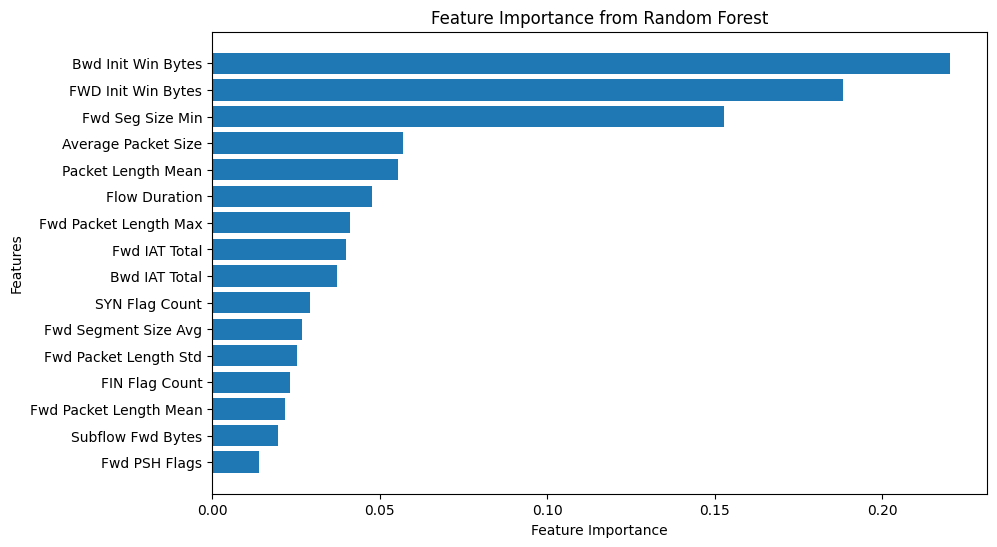

In [28]:
# Process 6 - Feature Importance validation using Random Forest Classifier.

# Ensure the target variable is properly encoded
tls_traffic['Label'] = tls_traffic['Label'].astype(int)  # Convert to integer if needed

# Separate features and target variable.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

# Initialize and train the Random Forest model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Calculate feature importance.
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualisation.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance.
print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

**Do Weighted scalling only if the accruracy is low**

In [29]:
# Process 7 - Weighted Scaling

# Calculate feature importance weights
importance_weights = selected_features / selected_features.sum()

# Apply weighted scaling to numeric columns
weighted_numeric_columns = numeric_columns.intersection(selected_features.index)

# Multiply each feature by its corresponding importance weight
for column in weighted_numeric_columns:
    tls_traffic[column] = tls_traffic[column] * importance_weights[column]

print("Weighted scaling completed!")

# Save the updated dataset for review.
tls_traffic.to_csv("7. Weighted scaled dataset.csv", index=False)
print("Weighted scaled dataset saved as '7. Weighted scaled dataset.csv'")

Weighted scaling completed!
Weighted scaled dataset saved as '7. Weighted scaled dataset.csv'


**Do ploynominal feature enhancement only if the accruracy is low**

In [10]:
# # Process 8 - Ploynominal Feature Enhancement

# # Ensure the column names are valid
# weighted_numeric_columns_list = list(weighted_numeric_columns)  # Define weighted numeric columns as a list

# # Step 1: Polynomial Features
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# # Filter valid columns in the dataset
# weighted_numeric_columns_list = [col for col in weighted_numeric_columns_list if col in tls_traffic.columns]

# # Transform the dataset for weighted numeric columns
# poly_features = poly.fit_transform(tls_traffic[weighted_numeric_columns_list])

# # Debug: Verify alignment
# print("Length of weighted_numeric_columns_list:", len(weighted_numeric_columns_list))
# print("Shape of poly_features:", poly_features.shape)
# print("Length of poly.powers_:", len(poly.powers_))

# # Step 2: Generate Feature Names Dynamically
# poly_feature_names = []
# for powers in poly.powers_:
#     poly_feature_names.append(
#         " * ".join(
#             f"{weighted_numeric_columns_list[i]}^{power}"
#             for i, power in enumerate(powers)
#             if i < len(weighted_numeric_columns_list) and power > 0
#         ) or "1"
#     )

# # Step 3: Combine Polynomial Features into the Dataset
# poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
# tls_traffic = pd.concat([tls_traffic.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

# # Step 4: Interaction Terms
# # Select the top 2 features based on their importance
# top_features = selected_features.sort_values(ascending=False).head(2).index.tolist()

# # Debug: Ensure top_features has exactly 2 valid columns
# print("Top features:", top_features)
# if len(top_features) < 2:
#     raise ValueError("Insufficient top features for interaction terms!")
# if tls_traffic[top_features[0]].ndim > 1 or tls_traffic[top_features[1]].ndim > 1:
#     raise ValueError(f"Unexpected multi-column selection in top_features: {top_features}")

# # Generate the interaction term for the top features
# interaction_term = tls_traffic[top_features[0]].astype(float) * tls_traffic[top_features[1]].astype(float)
# tls_traffic[f"Interaction_{top_features[0]}_x_{top_features[1]}"] = interaction_term

# print("Enhanced preprocessing pipeline applied successfully!")

# # Save the enhanced dataset
# tls_traffic.to_csv("8. Polynomial_Features_and_Interaction_Terms.csv", index=False)
# print("Enhanced dataset saved to '8. Polynomial_Features_and_Interaction_Terms.csv'")

In [30]:
# Feature Correlation Analysis
# Use selected_features from the feature selection process
important_features = selected_features.sort_values(ascending=False)  # Sort by correlation

# Print ranked features
print("Ranked Features Based on Correlation with Target Label:")
print(important_features)

# Optionally, create a DataFrame for better visualisation of correlation
feature_importance_df = important_features.reset_index()
feature_importance_df.columns = ["Feature", "Correlation"]
print("Feature Importance Table:")
print(feature_importance_df)

Ranked Features Based on Correlation with Target Label:
Fwd Seg Size Min          0.486229
FWD Init Win Bytes        0.265631
Bwd Init Win Bytes        0.240076
Fwd PSH Flags             0.182089
Fwd Segment Size Avg      0.159332
Fwd Packet Length Mean    0.159332
Fwd Packet Length Max     0.144930
Fwd IAT Total             0.143751
Flow Duration             0.142499
Bwd IAT Total             0.137290
Fwd Packet Length Std     0.132663
Subflow Fwd Bytes         0.132347
Average Packet Size       0.108640
Packet Length Mean        0.107494
FIN Flag Count           -0.172478
Timestamp                -0.195448
SYN Flag Count           -0.205988
Name: Label, dtype: float64
Feature Importance Table:
                   Feature  Correlation
0         Fwd Seg Size Min     0.486229
1       FWD Init Win Bytes     0.265631
2       Bwd Init Win Bytes     0.240076
3            Fwd PSH Flags     0.182089
4     Fwd Segment Size Avg     0.159332
5   Fwd Packet Length Mean     0.159332
6    Fwd Packet

In [31]:
# Process 6 - Splitting the dataset.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training and testing datasets created.")

Training and testing datasets created.


In [32]:
# Verify class distribution in the original dataset
print("Original dataset class distribution:")
print(y.value_counts(normalize=True))

# Verify class distribution in the training set
print("\nTraining dataset class distribution:")
print(y_train.value_counts(normalize=True))

# Verify class distribution in the testing set
print("\nTesting dataset class distribution:")
print(y_test.value_counts(normalize=True))

Original dataset class distribution:
0    0.25
1    0.25
2    0.25
3    0.25
Name: Label, dtype: float64

Training dataset class distribution:
1    0.25
0    0.25
2    0.25
3    0.25
Name: Label, dtype: float64

Testing dataset class distribution:
0    0.25
3    0.25
1    0.25
2    0.25
Name: Label, dtype: float64


In [33]:
# Ensure important_features matches the input features
important_features = selected_features.loc[
    tls_traffic.drop(columns=["Label"]).columns
].sort_values(ascending=False)

# Validate the number of important features matches num_qubits
assert len(important_features) == X_train.shape[1], "Number of features and feature weights mismatch!"

# Define the number of qubits based on the number of features
num_qubits = X_train.shape[1]

# Create a quantum device with the required number of qubits
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit with the QNode decorator
@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    # Apply feature weighting based on correlation
    weighted_inputs = inputs * tf.constant(important_features.values, dtype=tf.float32)
    
    # Embed classical data into the quantum circuit using AngleEmbedding
    qml.templates.AngleEmbedding(weighted_inputs, wires=range(num_qubits), rotation="Y")
    
    # Apply trainable quantum layers with entanglement
    qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    
    # Return the expectation values of PauliZ for all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Debugging Output
print(f"Number of qubits (wires) used: {len(dev.wires)}")

# Test the quantum circuit
inputs = tf.random.uniform((num_qubits,))
weights = tf.random.uniform((2, num_qubits))  # Shape matches num_layers and num_qubits
result = quantum_circuit(inputs, weights)

# Print the quantum circuit output
print("Quantum circuit output:", result)
print("Quantum device and circuit defined successfully!")

Number of qubits (wires) used: 16
Quantum circuit output: [<tf.Tensor: shape=(), dtype=float64, numpy=0.0226200967533961>, <tf.Tensor: shape=(), dtype=float64, numpy=0.005998809374407832>, <tf.Tensor: shape=(), dtype=float64, numpy=0.008418992289195293>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0016815945740152882>, <tf.Tensor: shape=(), dtype=float64, numpy=0.010794398388032755>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0023789966430686205>, <tf.Tensor: shape=(), dtype=float64, numpy=0.015815865516796368>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0026992651059163375>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02559636713796365>, <tf.Tensor: shape=(), dtype=float64, numpy=0.002670094462463579>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02429623272385717>, <tf.Tensor: shape=(), dtype=float64, numpy=0.002095047067764255>, <tf.Tensor: shape=(), dtype=float64, numpy=0.02917338856517321>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0017350482800130296>, <tf.Tensor: shape=

In [15]:
# Define the number of qubits based on the number of features
num_qubits = X_train.shape[1]

# Create a quantum device with the required number of qubits
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit with the QNode decorator
@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    # Embed classical data into the quantum circuit using AngleEmbedding
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits), rotation="Y")
    # Apply trainable quantum layers with entanglement
    qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    # Return the expectation values of PauliZ for all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Define the weight shape for the quantum circuit
num_layers = 2  # Number of layers in the quantum circuit
weight_shape = {"weights": (num_layers, num_qubits)}

# Create a custom Keras layer that integrates the quantum circuit
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Initialize trainable weights for the quantum circuit
        self.q_weights = self.add_weight(
            name="q_weights",
            shape=weight_shape["weights"],
            initializer="glorot_uniform",  # Use Glorot Uniform Initialiser
            trainable=True,
        )

    def call(self, inputs):
        # Function to execute the quantum circuit
        @tf.autograph.experimental.do_not_convert  # Suppress AutoGraph warnings here
        def circuit_execution(input_sample):
            # Call the quantum circuit
            result = quantum_circuit(input_sample, self.q_weights)
            # Ensure the output is converted to the correct dtype
            result = tf.cast(result, dtype=tf.float32)
            return result

        # Apply the quantum circuit to each input sample in the batch
        outputs = tf.map_fn(
            circuit_execution, inputs, fn_output_signature=tf.float32
        )
        return outputs

    def compute_output_shape(self, input_shape):
        # The output shape matches the number of qubits
        return (input_shape[0], num_qubits)

# Define the hybrid Quantum-Classical model
def create_hybrid_model(num_classes=1):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(num_qubits,)),  # Input layer matching the number of features
        QuantumLayer(),                      # Quantum layer for feature extraction
        tf.keras.layers.Flatten(),           # Flatten the output of the quantum layer
        tf.keras.layers.Dropout(0.3 if num_classes > 1 else 0.2),  # Adjust dropout dynamically
        tf.keras.layers.Dense(num_classes, activation="softmax" if num_classes > 1 else "sigmoid"),  # Output layer
    ])
    return model

# Create the model
num_classes = 4  # Change to 1 for binary classification or >1 for multiclass
hybrid_model = create_hybrid_model(num_classes=num_classes)

# Log configuration
print(f"Model configured for {'binary' if num_classes == 1 else 'multiclass'} classification with {num_classes} class(es).")

# Print the model summary
hybrid_model.summary()

# Compile the model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss="categorical_crossentropy" if num_classes > 1 else "binary_crossentropy",  # Loss based on the number of classes
    metrics=["accuracy"]
)

# Print confirmation
print("Hybrid Quantum-Classical model defined and compiled successfully!")

Model configured for multiclass classification with 4 class(es).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantum_layer (QuantumLayer  (None, 16)               32        
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Hybrid Quantum-Classical model defined and compiled success

In [16]:
# Convert target labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=4)  # Convert training labels
y_test_one_hot = to_categorical(y_test, num_classes=4)    # Convert testing labels

# Compile the model with categorical crossentropy
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss="categorical_crossentropy",  # Use categorical crossentropy for one-hot labels
    metrics=[
        "accuracy", 
        tf.keras.metrics.Precision(name="precision"),  # Track precision
        tf.keras.metrics.Recall(name="recall"),        # Track recall
    ]
)
print("Model compiled successfully!")


Model compiled successfully!


In [17]:
# Validate the shape of the one-hot encoded labels
print("Shape of y_train_one_hot:", y_train_one_hot.shape)  # Should be (number of training samples, num_classes)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)    # Should be (number of testing samples, num_classes)

# Ensure the number of classes matches the one-hot encoded dimensions
num_training_samples, num_classes_train = y_train_one_hot.shape
num_testing_samples, num_classes_test = y_test_one_hot.shape

assert num_classes_train == 4, "Mismatch in the number of training classes!"
assert num_classes_test == 4, "Mismatch in the number of testing classes!"

print("Number of training samples:", num_training_samples)
print("Number of testing samples:", num_testing_samples)
print("Number of classes:", num_classes_train)

print("Validation of one-hot encoding shapes completed successfully!")

Shape of y_train_one_hot: (36464, 4)
Shape of y_test_one_hot: (9116, 4)
Number of training samples: 36464
Number of testing samples: 9116
Number of classes: 4
Validation of one-hot encoding shapes completed successfully!


In [18]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",  # Save the best model based on validation loss
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

# Optional: Learning Rate Warmup
lr_warmup = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.001 * (epoch + 1) if epoch < 5 else 0.001
)

# Train the model
history = hybrid_model.fit(
    X_train,
    y_train_one_hot,  # Use one-hot encoded training labels
    epochs=50,        # Number of training epochs
    batch_size=32,    # Batch size
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1,  # Display training progress
    callbacks=[early_stopping, checkpoint, lr_scheduler, tensorboard, lr_warmup]  # Add callbacks
)

print("Model training complete!")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()